In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install split-folders
import tensorflow as tf
import keras
import cv2, pathlib, splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import *
from tensorflow.keras.layers import *
from keras import layers
from tensorflow.keras.models import Model, Sequential, load_model
from keras.layers.core import Dense,Flatten

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
epochs = 10
batch_size = 32
img_height, img_width = 64, 64
size = 64
input_shape = (img_height, img_width, 3)

In [4]:
data_dir = pathlib.Path('/content/drive/MyDrive/CS4641 project/ctscan_dataset/')

In [6]:
def generate_train_val(data_dir):
    data_dir = pathlib.Path(data_dir)
    splitfolders.ratio(data_dir, output='Imgs/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)


#generate_train_val('/content/drive/MyDrive/CS4641 project/ctscan_dataset/')

In [7]:
train_generator = ImageDataGenerator()
train_ds = train_generator.flow_from_directory('Imgs/train/',
                                         target_size=(img_height, img_width),
                                         class_mode='categorical')
val_generator = ImageDataGenerator()
val_ds = val_generator.flow_from_directory('Imgs/val/', target_size=(img_height, img_width),
                                          class_mode='categorical', shuffle=False)

test_generator = ImageDataGenerator()
test_ds = test_generator.flow_from_directory('Imgs/test/',
                                         target_size=(img_height, img_width),
                                         class_mode='categorical')

Found 1736 images belonging to 2 classes.
Found 371 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


In [12]:
from keras.applications import DenseNet121
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(size, size, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

model = build_densenet()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0   

In [13]:
#model.summary()
from keras.callbacks import ModelCheckpoint, EarlyStopping
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/CS4641 project/DenseNet121_model", verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [14]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, steps_per_epoch=50, callbacks=[checkpoint], validation_freq=1)

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 1.0709 - accuracy: 0.5685
Epoch 1: val_loss improved from inf to 0.70001, saving model to /content/drive/MyDrive/CS4641 project/DenseNet121_model
50/50 [==============================] - 212s 4s/step - loss: 1.0709 - accuracy: 0.5685 - val_loss: 0.7000 - val_accuracy: 0.6307
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.7170
Epoch 2: val_loss improved from 0.70001 to 0.60414, saving model to /content/drive/MyDrive/CS4641 project/DenseNet121_model
50/50 [==============================] - 209s 4s/step - loss: 0.7140 - accuracy: 0.7170 - val_loss: 0.6041 - val_accuracy: 0.7466
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.7912
Epoch 3: val_loss did not improve from 0.60414
50/50 [==============================] - 128s 3s/step - loss: 0.4889 - accuracy: 0.7912 - val_loss: 0.7405 - val_accuracy: 0.6927
Epoch 4/10
50/50 [===================

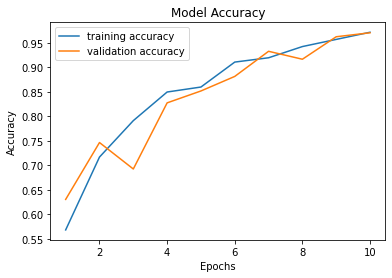

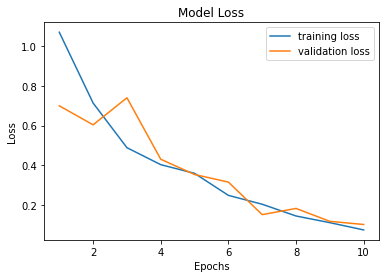

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig1, ax1 = plt.subplots()
ax1.set_title("Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epochs")
x = [1, 2, 3, 4, 5, 6,7,8,9,10]
ax1.plot(x, acc, label='training accuracy')
ax1.plot(x, val_acc, label='validation accuracy')

ax1.legend()

fig2, ax2 = plt.subplots()
ax2.set_title("Model Loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
ax2.plot(x, loss, label='training loss')
ax2.plot(x, val_loss, label='validation loss')

ax2.legend()
plt.show()

1/1 [==============================] - 0s 153ms/step


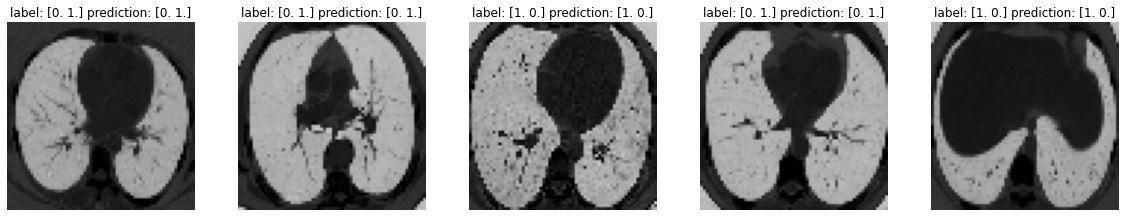

In [17]:
img, label = test_ds.next()
plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow((img[i] * 255).astype(np.uint8))
    image_resized= cv2.resize(img[i], (img_height,img_width))
    image=np.expand_dims(image_resized,axis=0)
    pred = model.predict(image)
    plt.title("label: " + str(label[i]) + " prediction: " + str(np.rint(pred[0])))
    plt.axis("off")